In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In this notebook we run multiple SVM models to predict the taxi demand for different time and location resolutions. Because there are many hexagons which are splitted into one feature each a full grid search with all hexagons is not feasible with the computing power we have available. Therefore we sample the data by  using 10 random hexagons for the hyperparameter optimization.

## Define Functions for Training SVM Models

In [2]:
def scale_data_and_get_dummies(data, location_bucket):
    # scale data except location bucket and demand
    col_scale_list = data.columns.to_list()
    col_scale_list.remove(location_bucket)
    col_scale_list.remove("demand")
    scaler = StandardScaler()
    data[col_scale_list] = scaler.fit_transform(data[col_scale_list])
    # create one hot encoding for location bucket feature
    data = pd.get_dummies(data, columns=[location_bucket], dtype=int)
    return data

def split_train_test(data, target_col="demand"):
    # split data into train and test
    X = data.drop(columns=[target_col])
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4711)
    return X_train, X_test, y_train, y_test 

In [3]:
#def grid_search_linear_svr(X_train, y_train, param_grid):
#    linear_svr_model = LinearSVR()
#    grid_search_linear = GridSearchCV(linear_svr_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
#    grid_search_linear.fit(X_train, y_train)
#    return grid_search_linear

# define parameter grids for different kernels

param_grid_linear = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
}

param_grid_poly = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], # 1
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'degree': [2, 3, 4, 5]
}

param_grid_rbf = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], # 1
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5] 
}

def grid_search_kernel_svr(X_train, y_train, param_grid, kernel):
    svr = SVR(kernel=kernel)
    grid_search_kernel = HalvingGridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    grid_search_kernel.fit(X_train, y_train)
    return grid_search_kernel

## Testing different Kernels

We start with a time resolution of 4 hours and a hexagon resolution of 6 to test different kernels via a grid search.

In [7]:
time_bucket_length = 4
location_bucket = "h3_06"

# read, scale and reate one hot encoding for location bucket feature
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print("data shape", data.shape)
scaled_data = scale_data_and_get_dummies(data, location_bucket)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

data shape (20558, 13)
X_train shape (16446, 35)
X_test shape (4112, 35)


### Linear Kernel

In [11]:
grid_result_linear = grid_search_kernel_svr(X_train, y_train, param_grid_linear, "linear")
grid_result_linear.best_params_

{'C': 100, 'epsilon': 0.5}

In [12]:
svr = SVR(kernel="linear", C=100, epsilon=0.5)
svr.fit(X_train, y_train)

SVR(C=100, epsilon=0.5, kernel='linear')

In [17]:
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

MAE: 483.26
MAPE: 4.81
MSE: 1468354.16
R2: 0.6761


### Polynomial Kernel

In [18]:
grid_result_poly = grid_search_kernel_svr(X_train, y_train, param_grid_poly, "poly")
grid_result_poly.best_params_

{'C': 100, 'degree': 2, 'epsilon': 0.4, 'gamma': 0.1}

In [19]:
svr = SVR(kernel="poly", C=100, degree=2, epsilon=0.4, gamma=0.1)
svr.fit(X_train, y_train)

SVR(C=100, degree=2, epsilon=0.4, gamma=0.1, kernel='poly')

In [20]:
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

MAE: 428.28
MAPE: 2.83
MSE: 1531490.17
R2: 0.6622


### RBF Kernel

In [21]:
grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
grid_result_rbf.best_params_

{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}

In [22]:
svr = SVR(kernel="rbf", C=100, epsilon=0.5, gamma=0.1)
svr.fit(X_train, y_train)

SVR(C=100, epsilon=0.5, gamma=0.1)

In [23]:
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred).round(2)
mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(4)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

MAE: 354.65
MAPE: 1.61
MSE: 978122.06
R2: 0.7842


Of the three Kernels tested with different hyperparameters, the RBF kernel seems to be the best one. Therefore we will pursue with the RBF Kernel model.

## check predictions

<Axes: xlabel='demand', ylabel='Count'>

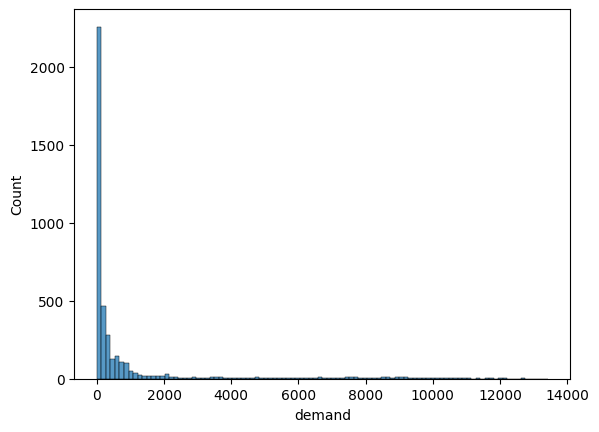

In [35]:
sns.histplot(y_test, bins=100)

If we look at the real data we can see that most taxi demands lie at lower values between 0 and 2000 and only a small fraction goes up until 14000. Therefore the model is probably a bit skewed and has a higher error.

In [46]:
print("shape all predictions", y_pred.shape)
print("shape negative predictions", y_pred[y_pred < 0].shape)
print("fraction negative predictions", (y_pred[y_pred < 0].shape[0]/y_pred.shape[0]).__round__(4)*100, "%")


shape all predictions (4112,)
shape negative predictions (253,)
fraction negative predictions 6.15 %


We can see that roughly 6% of predictions are negative, which cannot be true for a taxi demand. This is a major drawback of the SVM in comparison to other algorithms because it can also predict negative values.

## All time and location resolutions

In [4]:
time_bucket_lengths = [1, 2, 6, 24]
location_buckets = ["h3_05", "h3_06", "h3_07", "h3_08", "h3_09"] 

In [5]:
results = []
grid_dfs = []

#for time_bucket_length in time_bucket_lengths:
#    for location_bucket in location_buckets:

for time_bucket_length in [6, 24]:
    for location_bucket in ["h3_05", "h3_06"]:

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)

        # create sample from data with 10 hexagons
    #    sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30)
    #    data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
    #    print(data_sampled.shape)
    #    if data_sampled.shape[0] >= 50000:
    #        data_sampled = data_sampled.sample(50000, random_state=4711)
    #        print(data_sampled.shape)
        data_sampled = data

        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

        # run grid search for rbf kernel and save best params
        grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
        best_params = grid_result_rbf.best_params_

        # refit on best params
        svr = SVR(kernel="rbf", **best_params)
        svr.fit(X_train, y_train)

        # evaluate metrics
        y_pred = svr.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
        mse = mean_squared_error(y_test, y_pred).round(2)
        r2 = r2_score(y_test, y_pred).round(4)

        print("save best params and metrics")
        results.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "rbf_svr_best_params": best_params,
            "rbf_svr_best_score": grid_result_rbf.best_score_,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "r2": r2
        })
        
        print()

Time bucket length: 6h
Location bucket: h3_05
(8736, 13)
(8736, 20)


save best params and metrics

Time bucket length: 6h
Location bucket: h3_06
(14525, 13)
(14525, 36)
save best params and metrics

Time bucket length: 24h
Location bucket: h3_05
(2193, 12)
(2193, 19)
save best params and metrics

Time bucket length: 24h
Location bucket: h3_06
(4401, 12)
(4401, 35)
save best params and metrics



In [6]:
results

[{'time_bucket_length': 6,
  'location_bucket': 'h3_05',
  'rbf_svr_best_params': {'C': 100, 'epsilon': 0.4, 'gamma': 0.1},
  'rbf_svr_best_score': -6138507.471385362,
  'mae': 795.83,
  'mape': 1.74,
  'mse': 4745132.01,
  'r2': 0.7159},
 {'time_bucket_length': 6,
  'location_bucket': 'h3_06',
  'rbf_svr_best_params': {'C': 100, 'epsilon': 0.5, 'gamma': 0.1},
  'rbf_svr_best_score': -2497306.248561073,
  'mae': 511.04,
  'mape': 2.81,
  'mse': 2114939.46,
  'r2': 0.7563},
 {'time_bucket_length': 24,
  'location_bucket': 'h3_05',
  'rbf_svr_best_params': {'C': 100, 'epsilon': 0.4, 'gamma': 0.1},
  'rbf_svr_best_score': -207238904.0176059,
  'mae': 5791.52,
  'mape': 0.49,
  'mse': 190650492.72,
  'r2': 0.0756},
 {'time_bucket_length': 24,
  'location_bucket': 'h3_06',
  'rbf_svr_best_params': {'C': 100, 'epsilon': 0.2, 'gamma': 0.1},
  'rbf_svr_best_score': -75631206.27425593,
  'mae': 2551.17,
  'mape': 4.28,
  'mse': 64766691.24,
  'r2': 0.2126}]

In [7]:
results_df = pd.DataFrame(results)
results_df

,time_bucket_length,location_bucket,rbf_svr_best_params,rbf_svr_best_score,mae,mape,mse,r2
0,6,h3_05,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-6.138507e+06,795.83,1.74,4.745132e+06,0.7159
1,6,h3_06,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-2.497306e+06,511.04,2.81,2.114939e+06,0.7563
2,24,h3_05,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-2.072389e+08,5791.52,0.49,1.906505e+08,0.0756
3,24,h3_06,"{'C': 100, 'epsilon': 0.2, 'gamma': 0.1}",-7.563121e+07,2551.17,4.28,6.476669e+07,0.2126


In [5]:
results = []
grid_dfs = []

for time_bucket_length in time_bucket_lengths:
    for location_bucket in location_buckets:

#for time_bucket_length in [6, 24]:
#    for location_bucket in ["h3_07", "h3_08"]:

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)

        # create sample from data with 10 hexagons
        sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30)
        data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
        print(data_sampled.shape)
        if data_sampled.shape[0] >= 50000:
            data_sampled = data_sampled.sample(50000, random_state=4711)
            print(data_sampled.shape)
        
        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

        print("run LinearSVR")
        """
        grid_result_linear = grid_search_linear_svr(X_train, y_train, param_grid_linear)
        grid_df_linear = pd.DataFrame(grid_result_linear.cv_results_)
        grid_df_linear["location_bucket"] = location_bucket
        grid_df_linear["time_bucket_length"] = time_bucket_length
        grid_df_linear["model"] = "LinearSVR"
        """
        grid_result_linear = grid_search_kernel_svr(X_train, y_train, param_grid_linear, "linear")
        grid_df_linear = pd.DataFrame(grid_result_linear.cv_results_)
        grid_df_linear["location_bucket"] = location_bucket
        grid_df_linear["time_bucket_length"] = time_bucket_length
        grid_df_linear["model"] = "SVR_linear"
        

        print("run SVR poly kernel")
        grid_result_poly = grid_search_kernel_svr(X_train, y_train, param_grid_poly, "poly")
        grid_df_poly = pd.DataFrame(grid_result_poly.cv_results_)
        grid_df_poly["location_bucket"] = location_bucket
        grid_df_poly["time_bucket_length"] = time_bucket_length
        grid_df_poly["model"] = "SVR_poly"

        print("run SVR rbf kernel")
        grid_result_rbf = grid_search_kernel_svr(X_train, y_train, param_grid_rbf, "rbf")
        grid_df_rbf = pd.DataFrame(grid_result_rbf.cv_results_)
        grid_df_rbf["location_bucket"] = location_bucket
        grid_df_rbf["time_bucket_length"] = time_bucket_length
        grid_df_rbf["model"] = "SVR_rbf"

        print("concat results")
        grid_df = pd.concat([grid_df_linear, grid_df_poly, grid_df_rbf])
        grid_dfs.append(grid_df)

        print("save best params and scores")
        results.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "linear_svr_best_params": grid_result_linear.best_params_,
            "linear_svr_best_score": grid_result_linear.best_score_,
            "poly_svr_best_params": grid_result_poly.best_params_,
            "poly_svr_best_score": grid_result_poly.best_score_,
            "rbf_svr_best_params": grid_result_rbf.best_params_,
            "rbf_svr_best_score": grid_result_rbf.best_score_
        })
        
        print()

Time bucket length: 1h
Location bucket: h3_07
(163534, 13)
(54419, 13)
(50000, 13)
(50000, 42)
run LinearSVR
run SVR poly kernel
run SVR rbf kernel
concat results
save best params and scores

Time bucket length: 1h
Location bucket: h3_08
(410624, 13)
(37119, 13)
(37119, 42)
run LinearSVR
run SVR poly kernel
run SVR rbf kernel
concat results
save best params and scores

Time bucket length: 1h
Location bucket: h3_09
(572255, 13)
(51323, 13)
(50000, 13)
(50000, 42)
run LinearSVR
run SVR poly kernel
run SVR rbf kernel
concat results
save best params and scores

Time bucket length: 2h
Location bucket: h3_07
(94064, 13)
(42461, 13)
(42461, 42)
run LinearSVR
run SVR poly kernel
run SVR rbf kernel
concat results
save best params and scores

Time bucket length: 2h
Location bucket: h3_08
(245400, 13)
(18520, 13)
(18520, 42)
run LinearSVR
run SVR poly kernel
run SVR rbf kernel
concat results
save best params and scores

Time bucket length: 2h
Location bucket: h3_09
(349848, 13)
(12646, 13)
(12646

In [6]:
results_df = pd.DataFrame(results)
results_df

,time_bucket_length,location_bucket,linear_svr_best_params,linear_svr_best_score,poly_svr_best_params,poly_svr_best_score,rbf_svr_best_params,rbf_svr_best_score
0,1,h3_07,"{'C': 100, 'epsilon': 0.5}",-1132.674920,"{'C': 100, 'degree': 5, 'epsilon': 0.5, 'gamma...",-487.947837,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",-463.344932
1,1,h3_08,"{'C': 100, 'epsilon': 0.4}",-147.946813,"{'C': 10, 'degree': 3, 'epsilon': 0.5, 'gamma'...",-108.516354,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-66.731583
2,1,h3_09,"{'C': 100, 'epsilon': 0.5}",-393.269826,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'gamma...",-241.733899,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-147.142998
3,2,h3_07,"{'C': 100, 'epsilon': 0.5}",-8838.902119,"{'C': 100, 'degree': 4, 'epsilon': 0.5, 'gamma...",-3281.603961,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-3630.865769
4,2,h3_08,"{'C': 100, 'epsilon': 0.5}",-7664.302163,"{'C': 100, 'degree': 2, 'epsilon': 0.5, 'gamma...",-4239.208157,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-2441.572723
5,2,h3_09,"{'C': 100, 'epsilon': 0.5}",-109.050441,"{'C': 10, 'degree': 3, 'epsilon': 0.5, 'gamma'...",-53.410904,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-39.473681
6,6,h3_07,"{'C': 100, 'epsilon': 0.5}",-894824.070687,"{'C': 100, 'degree': 3, 'epsilon': 0.2, 'gamma...",-481422.460031,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-481105.051592
7,6,h3_08,"{'C': 10, 'epsilon': 0.5}",-12784.367415,"{'C': 100, 'degree': 4, 'epsilon': 0.5, 'gamma...",-2672.378799,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-3192.128520
8,6,h3_09,"{'C': 100, 'epsilon': 0.5}",-3742.162026,"{'C': 100, 'degree': 5, 'epsilon': 0.5, 'gamma...",-964.443289,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",-1474.611108
9,24,h3_07,"{'C': 100, 'epsilon': 0.5}",-302277.106648,"{'C': 100, 'degree': 3, 'epsilon': 0.2, 'gamma...",-221593.276857,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-149062.002409


In [7]:
results_df.to_csv("../../data/predictive/SVR_results_50000.csv", index=False)

In [8]:
results_df = pd.read_csv("../../data/predictive/SVR_results_50000.csv")
results_df

,time_bucket_length,location_bucket,linear_svr_best_params,linear_svr_best_score,poly_svr_best_params,poly_svr_best_score,rbf_svr_best_params,rbf_svr_best_score
0,1,h3_07,"{'C': 100, 'epsilon': 0.5}",-1132.674920,"{'C': 100, 'degree': 5, 'epsilon': 0.5, 'gamma...",-487.947837,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",-463.344932
1,1,h3_08,"{'C': 100, 'epsilon': 0.4}",-147.946813,"{'C': 10, 'degree': 3, 'epsilon': 0.5, 'gamma'...",-108.516354,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-66.731583
2,1,h3_09,"{'C': 100, 'epsilon': 0.5}",-393.269826,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'gamma...",-241.733899,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-147.142998
3,2,h3_07,"{'C': 100, 'epsilon': 0.5}",-8838.902119,"{'C': 100, 'degree': 4, 'epsilon': 0.5, 'gamma...",-3281.603961,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-3630.865769
4,2,h3_08,"{'C': 100, 'epsilon': 0.5}",-7664.302163,"{'C': 100, 'degree': 2, 'epsilon': 0.5, 'gamma...",-4239.208157,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-2441.572723
5,2,h3_09,"{'C': 100, 'epsilon': 0.5}",-109.050441,"{'C': 10, 'degree': 3, 'epsilon': 0.5, 'gamma'...",-53.410904,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-39.473681
6,6,h3_07,"{'C': 100, 'epsilon': 0.5}",-894824.070687,"{'C': 100, 'degree': 3, 'epsilon': 0.2, 'gamma...",-481422.460031,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-481105.051592
7,6,h3_08,"{'C': 10, 'epsilon': 0.5}",-12784.367415,"{'C': 100, 'degree': 4, 'epsilon': 0.5, 'gamma...",-2672.378799,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-3192.128520
8,6,h3_09,"{'C': 100, 'epsilon': 0.5}",-3742.162026,"{'C': 100, 'degree': 5, 'epsilon': 0.5, 'gamma...",-964.443289,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",-1474.611108
9,24,h3_07,"{'C': 100, 'epsilon': 0.5}",-302277.106648,"{'C': 100, 'degree': 3, 'epsilon': 0.2, 'gamma...",-221593.276857,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-149062.002409


In [9]:
result_graph_df = results_df
result_graph_df["linear_svr_best_score"] = result_graph_df["linear_svr_best_score"].round(2)*-1
result_graph_df["poly_svr_best_score"] = result_graph_df["poly_svr_best_score"].round(2)*-1
result_graph_df["rbf_svr_best_score"] = result_graph_df["rbf_svr_best_score"].round(2)*-1
result_graph_df

,time_bucket_length,location_bucket,linear_svr_best_params,linear_svr_best_score,poly_svr_best_params,poly_svr_best_score,rbf_svr_best_params,rbf_svr_best_score
0,1,h3_07,"{'C': 100, 'epsilon': 0.5}",1132.67,"{'C': 100, 'degree': 5, 'epsilon': 0.5, 'gamma...",487.95,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",463.34
1,1,h3_08,"{'C': 100, 'epsilon': 0.4}",147.95,"{'C': 10, 'degree': 3, 'epsilon': 0.5, 'gamma'...",108.52,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",66.73
2,1,h3_09,"{'C': 100, 'epsilon': 0.5}",393.27,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'gamma...",241.73,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",147.14
3,2,h3_07,"{'C': 100, 'epsilon': 0.5}",8838.90,"{'C': 100, 'degree': 4, 'epsilon': 0.5, 'gamma...",3281.60,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",3630.87
4,2,h3_08,"{'C': 100, 'epsilon': 0.5}",7664.30,"{'C': 100, 'degree': 2, 'epsilon': 0.5, 'gamma...",4239.21,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",2441.57
5,2,h3_09,"{'C': 100, 'epsilon': 0.5}",109.05,"{'C': 10, 'degree': 3, 'epsilon': 0.5, 'gamma'...",53.41,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",39.47
6,6,h3_07,"{'C': 100, 'epsilon': 0.5}",894824.07,"{'C': 100, 'degree': 3, 'epsilon': 0.2, 'gamma...",481422.46,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",481105.05
7,6,h3_08,"{'C': 10, 'epsilon': 0.5}",12784.37,"{'C': 100, 'degree': 4, 'epsilon': 0.5, 'gamma...",2672.38,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",3192.13
8,6,h3_09,"{'C': 100, 'epsilon': 0.5}",3742.16,"{'C': 100, 'degree': 5, 'epsilon': 0.5, 'gamma...",964.44,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",1474.61
9,24,h3_07,"{'C': 100, 'epsilon': 0.5}",302277.11,"{'C': 100, 'degree': 3, 'epsilon': 0.2, 'gamma...",221593.28,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",149062.00


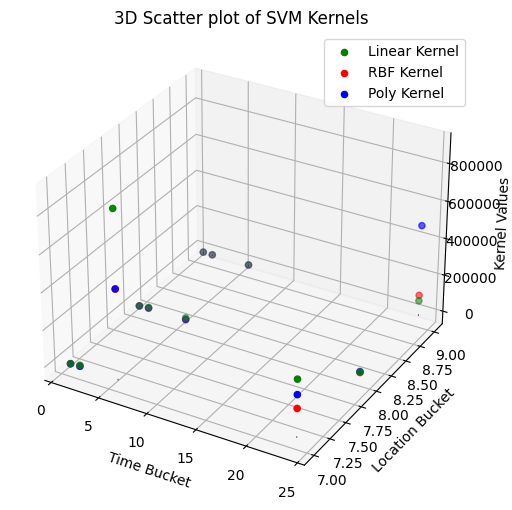

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Now you can proceed with your 3D scatter plot a

# Create the scatter plot
ax.scatter(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1])), result_graph_df['linear_svr_best_score'], color='green', label='Linear Kernel')
ax.scatter(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1])), result_graph_df['rbf_svr_best_score'], color='red', label='RBF Kernel')
ax.scatter(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1])), result_graph_df['poly_svr_best_score'], color='blue', label='Poly Kernel')

# Add z-axis lines for each point
for x, y in zip(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1]))):
    ax.plot([x, x], [y, y], [0, -5000], color='black', linewidth=0.5)


# Set labels
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Location Bucket')
ax.set_zlabel('Kernel Values')

plt.title('3D Scatter plot of SVM Kernels')
plt.legend()
plt.show()

In [11]:
result_graph_df = result_graph_df[:9]

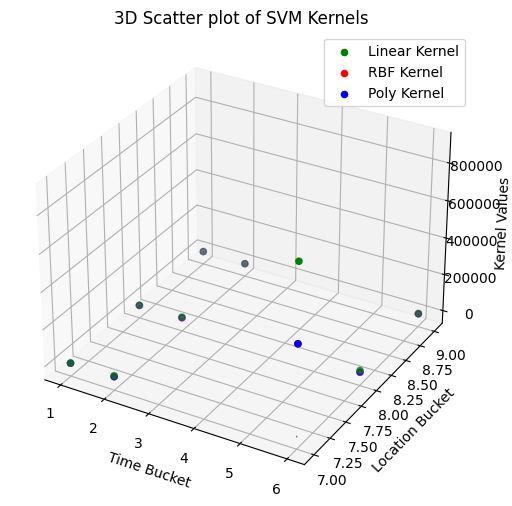

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Now you can proceed with your 3D scatter plot a

# Create the scatter plot
ax.scatter(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1])), result_graph_df['linear_svr_best_score'], color='green', label='Linear Kernel')
ax.scatter(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1])), result_graph_df['rbf_svr_best_score'], color='red', label='RBF Kernel')
ax.scatter(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1])), result_graph_df['poly_svr_best_score'], color='blue', label='Poly Kernel')

# Add z-axis lines for each point
for x, y in zip(result_graph_df['time_bucket_length'], result_graph_df['location_bucket'].apply(lambda x: int(x[-1]))):
    ax.plot([x, x], [y, y], [0, -5000], color='black', linewidth=0.5)


# Set labels
ax.set_xlabel('Time Bucket')
ax.set_ylabel('Location Bucket')
ax.set_zlabel('Kernel Values')

plt.title('3D Scatter plot of SVM Kernels')
plt.legend()
plt.show()

In [13]:
grid_dfs_list = [pd.DataFrame(grid_df) for grid_df in grid_dfs]
grid_dfs = pd.concat(grid_dfs_list)
grid_dfs

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,location_bucket,time_bucket_length,model,param_degree,param_gamma
0,0,4444,0.465308,0.015249,0.076295,0.014516,0.1,0.1,"{'C': 0.1, 'epsilon': 0.1}",-909.334570,...,-910.040834,-1216.804749,-1174.493649,-1164.225067,131.796740,h3_07,1,SVR_linear,NaN,NaN
1,0,4444,0.458851,0.045334,0.077619,0.010335,0.1,0.2,"{'C': 0.1, 'epsilon': 0.2}",-908.483302,...,-910.222548,-1217.131469,-1174.629259,-1164.094863,131.557673,h3_07,1,SVR_linear,NaN,NaN
2,0,4444,0.408562,0.015229,0.066574,0.005125,0.1,0.3,"{'C': 0.1, 'epsilon': 0.3}",-908.720248,...,-910.559313,-1217.492078,-1175.684528,-1164.545993,131.557435,h3_07,1,SVR_linear,NaN,NaN
3,0,4444,0.394400,0.023567,0.080986,0.027297,0.1,0.4,"{'C': 0.1, 'epsilon': 0.4}",-909.231898,...,-910.451584,-1217.530527,-1176.948576,-1165.057510,131.859146,h3_07,1,SVR_linear,NaN,NaN
4,0,4444,0.383869,0.015320,0.061343,0.007300,0.1,0.5,"{'C': 0.1, 'epsilon': 0.5}",-908.313848,...,-909.825585,-1217.830839,-1177.389933,-1164.715740,131.861979,h3_07,1,SVR_linear,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3,1134,0.048950,0.003620,0.020171,0.005885,100,0.3,"{'C': 100, 'epsilon': 0.3, 'gamma': 0.1}",-302596.147022,...,-338811.671922,-352199.846038,-423482.069524,-359871.487029,32404.383600,h3_09,24,SVR_rbf,NaN,0.1
148,3,1134,0.044615,0.006474,0.021440,0.003901,100,0.4,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-302579.921936,...,-338808.110752,-352203.450599,-423471.224992,-359865.181825,32401.876561,h3_09,24,SVR_rbf,NaN,0.1
149,3,1134,0.035745,0.001905,0.013761,0.001214,100,0.5,"{'C': 100, 'epsilon': 0.5, 'gamma': 0.1}",-302558.860402,...,-338792.703507,-352207.330961,-423464.889738,-359854.645038,32403.933543,h3_09,24,SVR_rbf,NaN,0.1
150,4,3402,0.308672,0.015254,0.151184,0.002774,100,0.4,"{'C': 100, 'epsilon': 0.4, 'gamma': 0.1}",-112004.996661,...,-115061.876584,-95869.254832,-104081.796988,-102846.840229,7170.175789,h3_09,24,SVR_rbf,NaN,0.1


In [14]:
grid_dfs.to_csv("../../data/predictive/SVR_results_grids_50000.csv", index=False)

## Train models

Bestes model bei time bucket 2, hexagon resolution 9 mit rbf kernel und diesen hyperparametern {'C': 100, 'epsilon': 0.5, 'gamma': 0.1}	.

In [66]:
time_bucket_length = 2
location_bucket = "h3_09"

In [15]:
print(f"Time bucket length: {time_bucket_length}h")
print(f"Location bucket: {location_bucket}")

# read in data
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print(data.shape)

# create sample from data with 10 hexagons
#sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 10)
#data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
#print(data_sampled.shape)
#if data_sampled.shape[0] >= 10000:
#    data_sampled = data_sampled.sample(10000, random_state=4711)
#    print(data_sampled.shape)

# scale data and create one hot encoding for location bucket feature
scaled_data = scale_data_and_get_dummies(data, location_bucket)
print(scaled_data.shape)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)


Time bucket length: 24h
Location bucket: h3_09
(62570, 12)
(62570, 449)


In [16]:
# train model
model = SVR(C=100, epsilon=0.5, gamma=0.1, kernel="rbf")
model.fit(X_train, y_train)

SVR(C=100, epsilon=0.5, gamma=0.1)

In [17]:
# evaluate model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test[:100], y_pred[:100]).round(2)
mse = mean_squared_error(y_test[:100], y_pred[:100]).round(2)
r2 = r2_score(y_test[:100], y_pred[:100]).round(4)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

KeyboardInterrupt: 

In [18]:
time_bucket_length = 2
location_bucket = "h3_09"

In [19]:
print(f"Time bucket length: {time_bucket_length}h")
print(f"Location bucket: {location_bucket}")

# read in data
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print(data.shape)

# create sample from data with 10 hexagons
#sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 10)
#data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
#print(data_sampled.shape)
#if data_sampled.shape[0] >= 10000:
#    data_sampled = data_sampled.sample(10000, random_state=4711)
#    print(data_sampled.shape)

# scale data and create one hot encoding for location bucket feature
scaled_data = scale_data_and_get_dummies(data, location_bucket)
print(scaled_data.shape)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)

Time bucket length: 2h
Location bucket: h3_09
(349848, 13)
(349848, 450)


In [20]:
# train model
model_2h_h9 = SVR(C=100, epsilon=0.5, gamma=0.1, kernel="rbf")
model_2h_h9.fit(X_train, y_train)

In [ ]:
# evaluate model
y_pred = model_2h_h9.predict(X_test)
mae = mean_absolute_error(y_test[:100], y_pred[:100]).round(2)
mse = mean_squared_error(y_test[:100], y_pred[:100]).round(2)
r2 = r2_score(y_test[:100], y_pred[:100]).round(4)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")